# BLM_4: Spectrogram
Spectrograms are the work horse of bioacousticians to visualize complex acoustic data.

In a nutshell, spectrograms are a sequence of power spectra carried out over consecutive small time slices of the acoutsic recording. To compensate for windowing edge effects and to 'smooth' temporal appearence, temporal overlap is implemented.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
plt.rcParams.update({'font.size': 14}) # increase fontsize in figures

## Theory

Signal RMS :  2.0 2.0
Noise  509.2726147610746


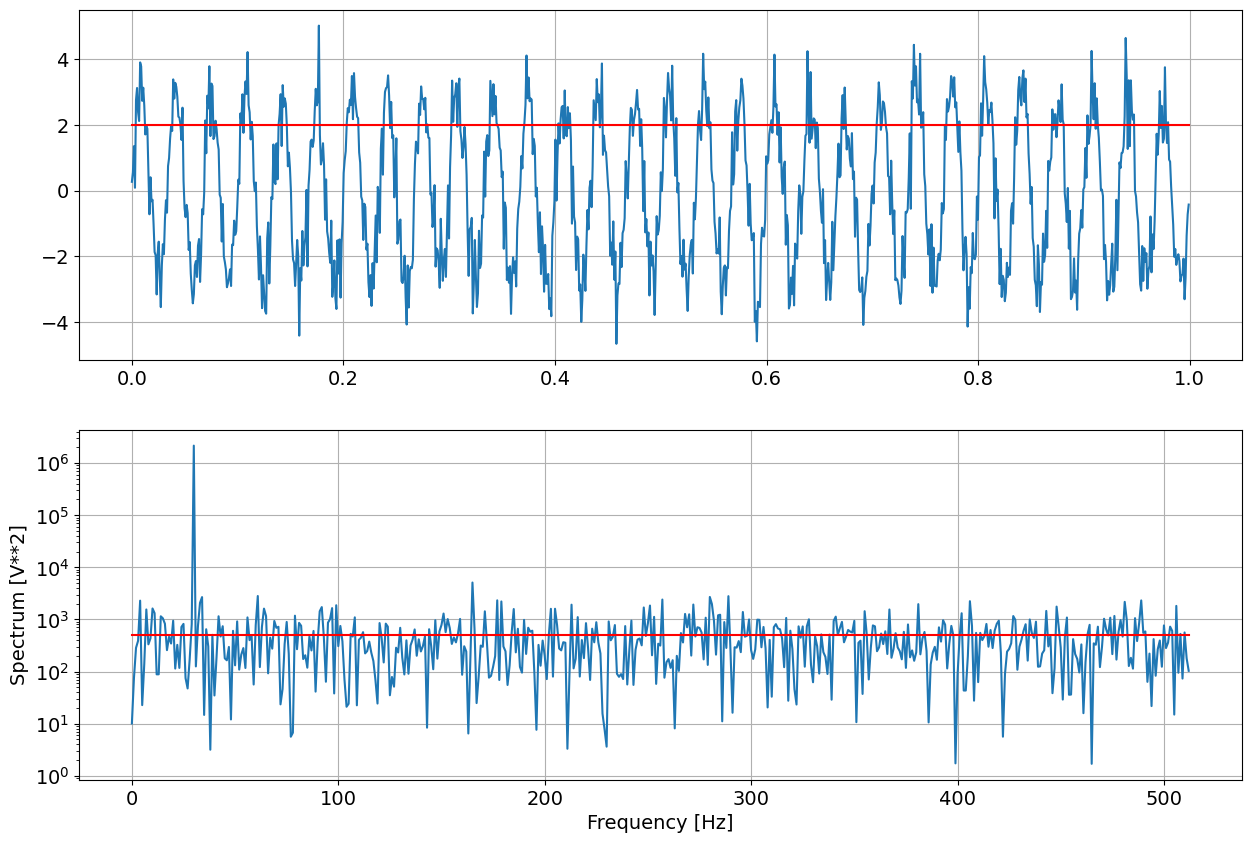

In [17]:
fs = 1024   #Hz
nfft=1024
nwin=nfft

#    Generate a 1 second test signal, a 2 Vrms sine wave at fs/8, corrupted by
#    0.001 V**2/Hz of white noise sampled at  1.024 kHz.

N = fs
time = np.arange(N) / fs

# signal description
arms=2
amp = arms*np.sqrt(2)
freq = 30

var = 0.001
noise_power = var * fs / 2 
# The factor of fs/2 converts the per sample noise power (variance) to a noise bandwith of -1/T to 1/T (negative and positive frequencies) 

xx = amp*np.sin(2*np.pi*freq*time)
rms= np.sqrt(np.mean(xx**2))

# add noise to signal
xx += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

print("Signal RMS : ",amp/np.sqrt(2), rms)

#
yy=np.fft.rfft(xx,nfft)
pp=np.abs(yy)**2

ff=np.arange(int(nfft/2)+1)*fs/nfft

ppmn=np.mean(pp[ff>50])
print("Noise ",ppmn)

fig = plt.figure("figure.figsize",[15,10])

plt.subplot(211)
plt.plot(time,xx)
plt.grid(True)
plt.plot(time,amp/np.sqrt(2)+0*time,'r')

plt.subplot(212)
plt.semilogy(ff, pp)
plt.plot(ff,ppmn+0*ff,'r')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Spectrum [V**2]')
plt.grid(True)

Signal RMS :  2.0 1.9999533593066727
Noise  584.6639373607219


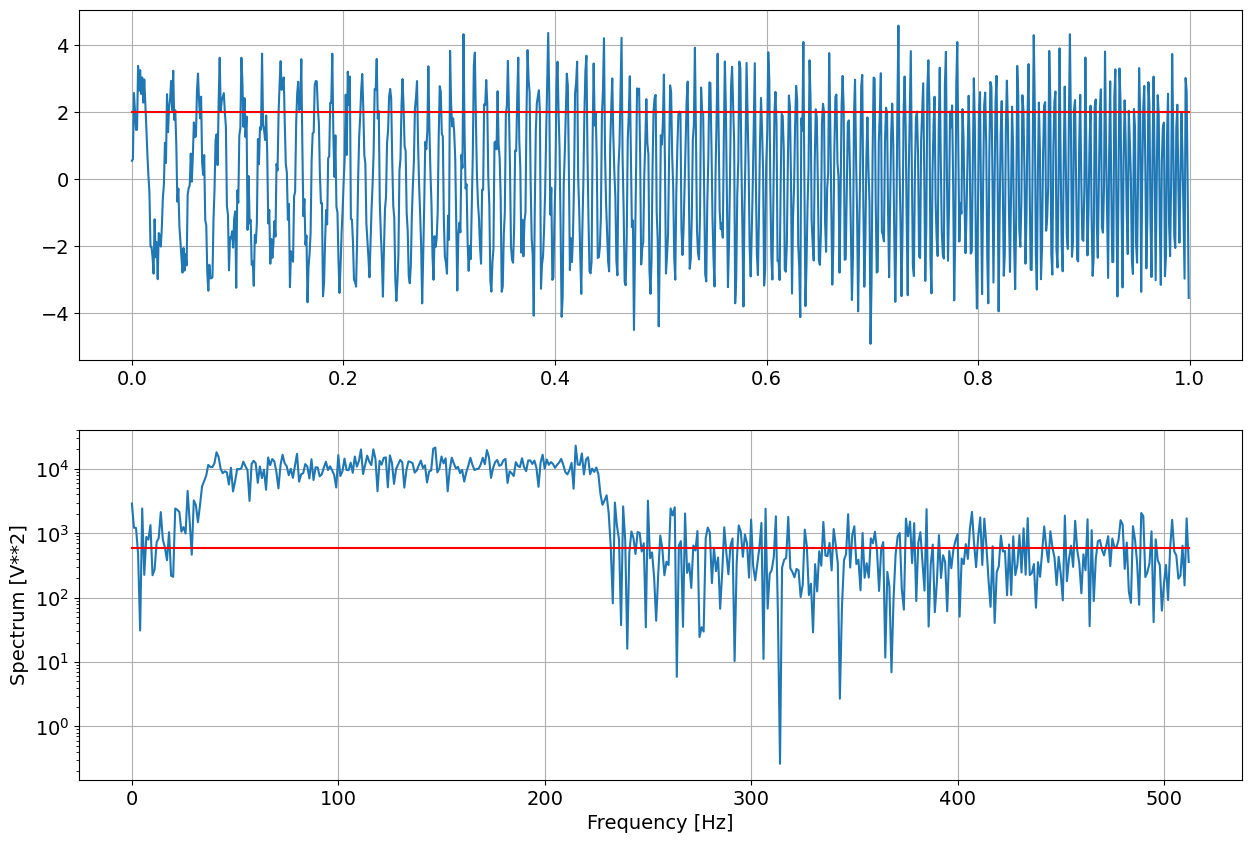

In [18]:
fs = 1024   #Hz
nfft=1024
nwin=nfft

#    Generate a 1 second test signal, a 2 Vrms sine wave at fs/8, corrupted by
#    0.001 V**2/Hz of white noise sampled at  1.024 kHz.

N = fs
time = np.arange(N) / fs

# signal description
arms=2
amp = arms*np.sqrt(2)

freq = 30
bw=200

xx = amp*np.sin(2*np.pi*(freq+bw/2*time)*time)
rms= np.sqrt(np.mean(xx**2))

# add noise to signal
var = 0.001
noise_power = var * fs / 2 
# The factor of fs/2 converts the per sample noise power (variance) to a noise bandwith of -1/T to 1/T (negative and positive frequencies) 


xx += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

print("Signal RMS : ",amp/np.sqrt(2), rms)

#
yy=np.fft.rfft(xx,nfft)
pp=np.abs(yy)**2

ff=np.arange(int(nfft/2)+1)*fs/nfft

ppmn=np.mean(pp[ff>250])
print("Noise ",ppmn)

fig = plt.figure("figure.figsize",[15,10])

plt.subplot(211)
plt.plot(time,xx)
plt.grid(True)
plt.plot(time,amp/np.sqrt(2)+0*time,'r')

plt.subplot(212)
plt.semilogy(ff, pp)
plt.plot(ff,ppmn+0*ff,'r')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Spectrum [V**2]')
plt.grid(True)
plt.show()


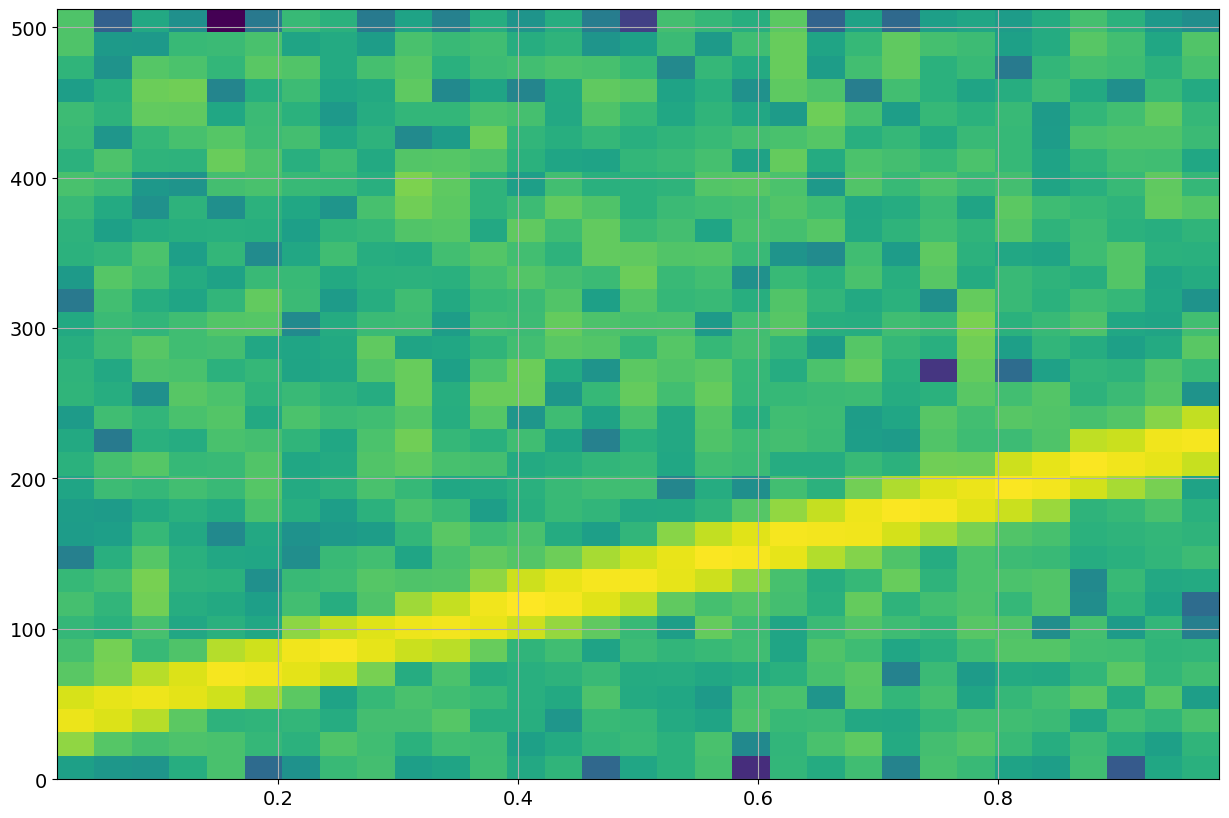

In [19]:
fig = plt.figure("figure.figsize",[15,10])

plt.specgram(xx,64,1024,noverlap=32)
plt.grid(True)
plt.show()

## LFM sweep

\begin{equation}
x(t)= \sin{(2\pi f_0 t)}
\end{equation}
becomes
\begin{equation}
x(t)= \sin{(2\pi(f_0+\frac{B}{2}t)t)}=\sin{(2\pi(f_0 t+\frac{B}{2}t^2))}=\sin{(\phi(t))}
\end{equation}

Frequency estimation from data
 
\begin{equation}
f(t) = \frac{1}{2\pi}\frac{d}{dt} \phi(t) = f_0+Bt
\end{equation}

## Real Example

In [20]:

# custom spectrum estimation
def mSpectrum(xx,win,fs,nfft,mode=None):
    # xx: real valued time series if at least nfft samples
    # nfft: length of fft in samples
    # fs: sampling frequency
    # mode: RMS for scaling of spectral peakes to signal RMS
    #       VAR for scaling of spectral mean values to per sample variance
    #       PSD for scaling of power spectral density to (v^2/Hz)
    #       None for power spectrum (FFT output) (Default)
    # output: P power estimates according to mode
    #         ff frequency vector
    nwin=len(win)
    if nfft<nwin: nfft=nwin # force nfft to be at least window length
    nfft=int(2**np.ceil(np.log2(nfft))) # increase nfft to next power of 2
    #
    # copy data to working buffer zero-pad if required
    uu=np.zeros(nfft)
    uu[:nwin]=xx[:nwin]*win
    
    yy=np.fft.rfft(uu,nfft)
    ff=np.arange(int(nfft/2)+1)*fs/nfft

    pp=np.abs(yy)**2
    if mode=="RMS":
        return pp/win.sum()**2, ff
    elif mode=="VAR":
        pp[1:] *=2
        return pp/(nwin*(win*win).sum()), ff
    elif mode=="PSD":
        pp[1:] *=2
        return pp/(fs*(win*win).sum()), ff
    else:
        return pp, ff


### Load some data


xx=  (308700, 1)
S=  (513, 1203)


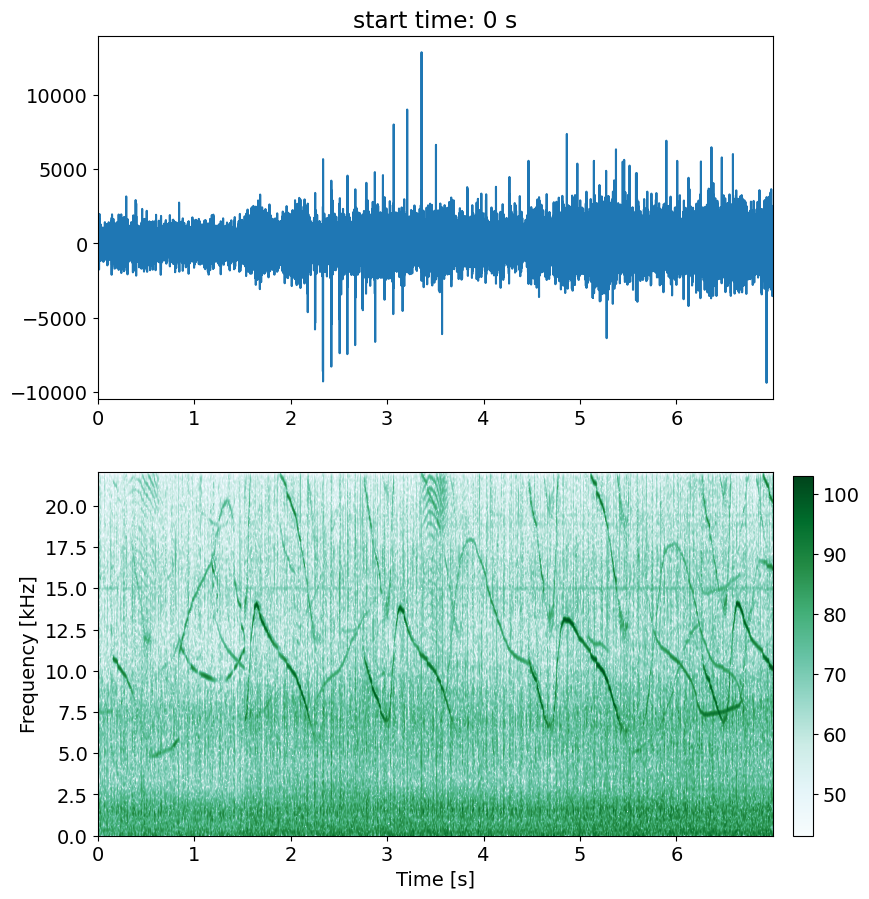

In [21]:
fname="../Data/Stenella.wav"

import wave

ich=0

no=0
ns=7

wf = wave.open(fname)
fs=wf.getframerate()
nch=wf.getnchannels()
#
nd=wf.getnframes()
if no*fs < nd:  
    wf.setpos(no*fs)
else:
    print("offset ",no," > ",nd/fs)

nd -= no*fs
#
nx = ns*fs
if nx> nd: nx=nd
xb=wf.readframes(nx)
wf.close()

xx=np.frombuffer(xb, dtype=np.int16).reshape(nx,nch)
if nch>1:
    xx = xx[:,ich]

print("xx= ",np.shape(xx))
tt=np.arange(nx)/fs

fig = plt.figure("figsize",[10,10])
ax1=plt.subplot(211)
plt.plot(tt,xx);
plt.xlim(0,tt[-1])
plt.title('start time: '+str(no)+' s')

# spectrogram
nw=512
nst=int(nw/2)
nfft=int(2*nw)
nfr=int(1+nfft/2)

ww=np.hanning(nw)
n2=int((nx-nw)/nw*2)
#
S = np.zeros((nfr,n2))
for ii in range(n2):
    io=ii*nst
    uu = xx[io:(io+nw),ich]*ww
    S[:,ii],ff = mSpectrum(uu,ww,fs,nfft)
print("S= ",np.shape(S))

# for too many time bins compress (peak picking) for better visualization (emphasize clicks)
if n2>1000:
    M = np.zeros((nfr,1000))
    for ii in range(n2):
        jj = int(ii*1000/n2)
        M[:,jj] = np.maximum(M[:,jj],S[:,ii])
else:
    M = S

mx=10*np.log10(np.max(M))
#cmap='winter'
#cmap='YlGnBu'
cmap='BuGn'
ax2=plt.subplot(212,sharex=ax1)
im=plt.imshow(10*np.log10(M), cmap=cmap,origin='lower', aspect='auto',extent=(0,ns,0,ff[-1]/1000),clim=(mx-60,mx))
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.82, 0.1, 0.02, 0.36])
plt.colorbar(cax=cax)
plt.show()
